In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm import tqdm

tqdm.pandas()

In [2]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)


color_palette = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Grade Analysis

In [3]:
def apply_group(id):
    if id in [1, 2, 3, 4]:
        return '1-4'
    elif id in [5, 6, 7, 8]:
        return '5-8'
    elif id in [9, 10, 11, 12]:
        return '9-12'
    elif id in [13, 14, 15, 16]:
        return '13-16'
    elif id in [17, 18, 19, 20]:
        return '17-20'
    elif id in [21, 22, 23, 24]:
        return '21-24'
    else:
        return '25-28'

In [4]:
grade_df = pd.read_csv('Menagerie/data/grades.csv', index_col=0)
grade_df = grade_df[~grade_df['grade'].isnull()]
grade_df['grade'] = pd.Categorical(grade_df['grade'],
                                         ['A++', 'A+', 'A', 'A-',
                                          'B+', 'B', 'B-',
                                          'C+', 'C', 'C-',
                                          'D+', 'D', 'D-',
                                          'F', 'NAN'])

grade_df['primary_grade'] = grade_df['grade'].apply(lambda x: x[0])
grade_df['primary_grade'] = pd.Categorical(grade_df['primary_grade'], ['A', 'B', 'C', 'D', 'F'])

grade_df['group'] = grade_df['participant_id'].apply(apply_group)
grade_df['group'] = pd.Categorical(grade_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])


# Removed as this was accidentally duplicated
grade_df = grade_df[grade_df['assignment_number'] != 105]
grade_df

,assignment_number,comments,skill,participant_id,batch,grade,primary_grade,group
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,B,13-16
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,A,13-16
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,A,13-16
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,A,13-16
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,A,13-16
...,...,...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++,A,13-16
16,353.0,NaN,Documentation,14,1,A++,A,13-16
17,422.0,NaN,Documentation,14,1,A++,A,13-16
18,480.0,NaN,Documentation,14,1,A++,A,13-16


# Inter-Rater Analysis

In [5]:
def merge_grades(row):
    if row[row.index[0]] >= row[row.index[1]]:
        return str(row[row.index[0]]) + str(row[row.index[1]])
    else:
        return str(row[row.index[1]]) + str(row[row.index[0]])

In [6]:
GRADE_DICT = {i:v for i, v in enumerate(grade_df['grade'].sort_values().unique())}
ONE_AWAY_GRADES = [g+g for g in grade_df['grade'].sort_values().unique()] + [GRADE_DICT[i] + GRADE_DICT[i + 1] for i in range(len(GRADE_DICT.keys()) - 1)]
ONE_AWAY_GRADES

['A++A++',
 'A+A+',
 'AA',
 'A-A-',
 'B+B+',
 'BB',
 'B-B-',
 'C+C+',
 'CC',
 'C-C-',
 'D+D+',
 'DD',
 'D-D-',
 'FF',
 'NANNAN',
 'A++A+',
 'A+A',
 'AA-',
 'A-B+',
 'B+B',
 'BB-',
 'B-C+',
 'C+C',
 'CC-',
 'C-D+',
 'D+D',
 'DD-',
 'D-F',
 'FNAN']

In [7]:
def one_away_fleiss_kappa(table):
    table = 1.0 * np.asarray(table)
    submission_count = table.shape[0]
    ratings_count = table.sum()
    grade_count = table.shape[1]
    number_of_graders = 4

    p_j = [table[:, i].sum() / ratings_count for i in range(grade_count)]
    p_i = [(sum(table[i, :] * table[i, :]) - number_of_graders) / (number_of_graders * (number_of_graders - 1)) for i in range(submission_count)]

    p_bar = sum(p_i) / submission_count
    p_e_bar = sum([j * j for j in p_j])

    kappa = (p_bar - p_e_bar) / (1 - p_e_bar)

    return kappa

In [8]:
def calculate_fleiss_kappa(skill, group, grade_col, one_away):
    
    skill_df = grade_df[grade_df['skill'] == skill][['participant_id', 'assignment_number', 'group', grade_col]]
    
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')
    pivot = group_df.pivot(index='assignment_number', columns='participant_id', values=grade_col)
    if any(pivot.isna().any(axis=1)):
        print('Missing Grade: ', pivot[pivot.isna().any(axis=1)])
        pivot.dropna(inplace=True)

    # Combinations adapted from: https://stackoverflow.com/questions/43347939/all-possible-combinations-of-columns-in-dataframe-pandas-python
    if one_away:
        participant_combinations = list(combinations(pivot.columns, 2))
        one_away_grade_df = pd.concat([pivot[[c[0], c[1]]].apply(lambda row: merge_grades(row), axis=1) for c in participant_combinations], axis=1, keys=participant_combinations)
        one_away_grade_df.columns = [f'{c[0]}-{c[1]}' for c in participant_combinations]
        
        aggregate_grades = aggregate_raters(one_away_grade_df)
        aggregate_grades_df = pd.DataFrame(aggregate_grades[0], columns=aggregate_grades[1])
        aggregate_grades_df = aggregate_grades_df[aggregate_grades_df.columns.intersection(ONE_AWAY_GRADES)]

        return one_away_fleiss_kappa(aggregate_grades_df.to_numpy())
  
    return fleiss_kappa(aggregate_raters(pivot)[0], 'fleiss')

In [9]:
calculate_fleiss_kappa('Correctness', '1-4', 'grade', True)

-0.1219424691569568

In [10]:
def calculate_all_fleiss_kappa(grade_col='grade', one_away=False):
    results_df = None
    
    for skill in ['Correctness', 'Readability', 'Code Elegance', 'Documentation']:
        for group in grade_df['group'].unique():
            try:
                results_df = pd.concat([results_df, pd.DataFrame({
                                        'group': group,
                                        'skill': skill,
                                        'fliess_kappa': calculate_fleiss_kappa(skill, group, grade_col, one_away)}, index=[0])])
            except ValueError as e:
                print('Error duplicate entries check data for: ', group)
                # raise e
    
    return results_df

### Fine-Grained

In [11]:
fine_df = calculate_all_fleiss_kappa()
fine_df

Missing Grade:  participant_id      13  14  15 16
assignment_number                
306.0              NaN  A+  B+  A
Missing Grade:  participant_id      21   22   23  24
assignment_number                   
10.0               NaN   A+   D+   F
410.0              NaN   C+   A+  A-
654.0              NaN  A++  A++  D-
Missing Grade:  participant_id      25   26   27   28
assignment_number                    
394.0              A++  A++  NaN  A++
Missing Grade:  participant_id      9  10  11  12
assignment_number                
117.0              NaN  B  A+  A-


,group,skill,fliess_kappa
0,13-16,Correctness,0.041807
0,21-24,Correctness,0.128276
0,25-28,Correctness,0.046496
0,5-8,Correctness,-0.024104
0,1-4,Correctness,0.042673
0,17-20,Correctness,0.113360
0,9-12,Correctness,0.003440
0,13-16,Readability,-0.057512
0,21-24,Readability,0.036232
0,25-28,Readability,0.077050


In [12]:
fine_pivot = fine_df.sort_values(by='group').pivot(index='group', columns='skill', values='fliess_kappa')
fine_pivot

skill,Code Elegance,Correctness,Documentation,Readability
group,,,,
1-4,-0.003257,0.042673,0.001796,-0.002874
13-16,0.016196,0.041807,-0.001155,-0.057512
17-20,0.035119,0.113360,0.003831,-0.010288
21-24,0.017310,0.128276,-0.036180,0.036232
25-28,0.081149,0.046496,0.063255,0.077050
5-8,-0.013182,-0.024104,-0.071363,-0.070433
9-12,-0.026386,0.003440,-0.059063,-0.069315


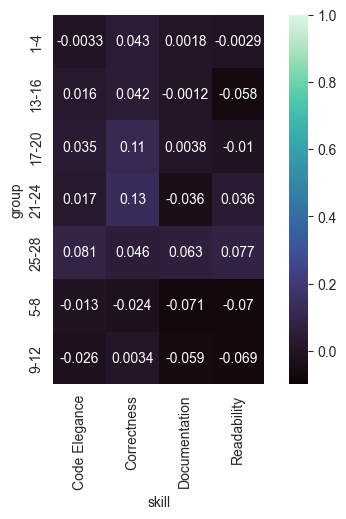

In [13]:
g = sns.heatmap(fine_pivot, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/fleiss_kappa_fine.pdf', bbox_inches='tight')

### Average Fliess Kappa
#### Skill

In [14]:
fine_df[['skill', 'fliess_kappa']].groupby('skill').mean().reset_index()

,skill,fliess_kappa
0,Code Elegance,0.015278
1,Correctness,0.050278
2,Documentation,-0.014126
3,Readability,-0.013877


#### Group

In [15]:
fine_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()

,group,fliess_kappa
0,1-4,0.009584
1,13-16,-0.000166
2,17-20,0.035506
3,21-24,0.036410
4,25-28,0.066987
5,5-8,-0.044771
6,9-12,-0.037831


## One Away Analysis

In [16]:
one_away_df = calculate_all_fleiss_kappa(one_away=True)
one_away_df

Missing Grade:  participant_id      13  14  15 16
assignment_number                
306.0              NaN  A+  B+  A
Missing Grade:  participant_id      21   22   23  24
assignment_number                   
10.0               NaN   A+   D+   F
410.0              NaN   C+   A+  A-
654.0              NaN  A++  A++  D-
Missing Grade:  participant_id      25   26   27   28
assignment_number                    
394.0              A++  A++  NaN  A++
Missing Grade:  participant_id      9  10  11  12
assignment_number                
117.0              NaN  B  A+  A-


,group,skill,fliess_kappa
0,13-16,Correctness,-0.035726
0,21-24,Correctness,0.407588
0,25-28,Correctness,-0.011615
0,5-8,Correctness,-0.319973
0,1-4,Correctness,-0.121942
0,17-20,Correctness,0.050462
0,9-12,Correctness,-0.412498
0,13-16,Readability,-0.275000
0,21-24,Readability,0.074293
0,25-28,Readability,0.048151


In [17]:
one_away_pivot = one_away_df.sort_values(by='group').pivot(index='group', columns='skill', values='fliess_kappa')
one_away_pivot

skill,Code Elegance,Correctness,Documentation,Readability
group,,,,
1-4,-0.198943,-0.121942,-0.250964,-0.224907
13-16,-0.283567,-0.035726,-0.232839,-0.275000
17-20,-0.291473,0.050462,-0.392551,-0.326226
21-24,-0.115714,0.407588,-0.514260,0.074293
25-28,-0.003766,-0.011615,0.199552,0.048151
5-8,-0.396712,-0.319973,-0.638294,-0.364953
9-12,-0.449176,-0.412498,-0.452991,-0.467427


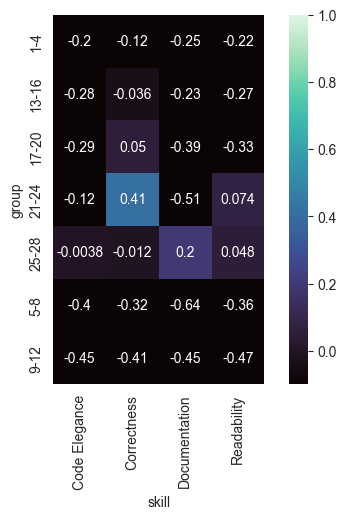

In [18]:
g = sns.heatmap(one_away_pivot, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/fleiss_kappa_one_away.pdf', bbox_inches='tight')

### Average Fliess Kappa
#### Skill

In [19]:
one_away_df[['skill', 'fliess_kappa']].groupby('skill').mean().reset_index()

,skill,fliess_kappa
0,Code Elegance,-0.248479
1,Correctness,-0.063386
2,Documentation,-0.326050
3,Readability,-0.219438


#### Group

In [20]:
one_away_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()

,group,fliess_kappa
0,1-4,-0.199189
1,13-16,-0.206783
2,17-20,-0.239947
3,21-24,-0.037023
4,25-28,0.058080
5,5-8,-0.429983
6,9-12,-0.445523


## Less granular analysis

In [21]:
coarse_df = calculate_all_fleiss_kappa('primary_grade')
coarse_df

Missing Grade:  participant_id      13 14 15 16
assignment_number              
306.0              NaN  A  B  A
Missing Grade:  participant_id      21 22 23 24
assignment_number              
10.0               NaN  A  D  F
410.0              NaN  C  A  A
654.0              NaN  A  A  D
Missing Grade:  participant_id      21 22 23 24
assignment_number              
10.0               NaN  A  B  A
51.0               NaN  F  F  A
77.0               NaN  B  B  A
124.0              NaN  A  B  A
160.0              NaN  A  B  B
252.0              NaN  A  A  A
292.0              NaN  A  A  A
311.0              NaN  B  A  C
410.0              NaN  B  A  A
473.0              NaN  A  B  A
490.0              NaN  A  A  B
523.0              NaN  A  A  A
549.0              NaN  A  B  A
624.0              NaN  A  A  B
654.0              NaN  A  A  B
Missing Grade:  participant_id    25 26   27 28
assignment_number              
394.0              A  A  NaN  A
Missing Grade:  participant_id      9  1

,group,skill,fliess_kappa
0,13-16,Correctness,0.276003
0,21-24,Correctness,0.379183
0,25-28,Correctness,0.284534
0,5-8,Correctness,-0.016199
0,1-4,Correctness,0.245128
0,17-20,Correctness,0.266433
0,9-12,Correctness,0.054746
0,13-16,Readability,-0.002580
0,21-24,Readability,0.020133
0,25-28,Readability,0.235238


In [22]:
coarse_pivot = coarse_df.sort_values(by='group').pivot(index='group', columns='skill', values='fliess_kappa')
coarse_pivot

skill,Code Elegance,Correctness,Documentation,Readability
group,,,,
1-4,0.110633,0.245128,0.153560,0.141092
13-16,-0.083827,0.276003,0.025875,-0.002580
17-20,0.104167,0.266433,-0.030889,0.070727
21-24,0.072285,0.379183,0.061566,0.020133
25-28,0.165580,0.284534,0.341574,0.235238
5-8,-0.072377,-0.016199,-0.085587,-0.061360
9-12,-0.038231,0.054746,-0.101362,-0.010668


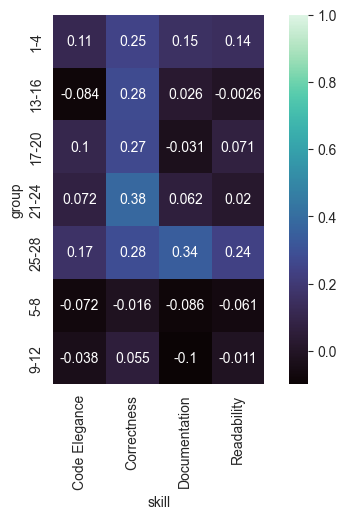

In [23]:
g = sns.heatmap(coarse_pivot, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/fleiss_kappa_coarse.pdf', bbox_inches='tight')

### Average Fliess Kappa
#### Skill

In [24]:
coarse_df[['skill', 'fliess_kappa']].groupby('skill').mean().reset_index()

,skill,fliess_kappa
0,Code Elegance,0.036890
1,Correctness,0.212833
2,Documentation,0.052105
3,Readability,0.056083


#### Group

In [25]:
coarse_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()

,group,fliess_kappa
0,1-4,0.162603
1,13-16,0.053868
2,17-20,0.102609
3,21-24,0.133292
4,25-28,0.256731
5,5-8,-0.058881
6,9-12,-0.023879


## Distance between grades

In [26]:
def get_grade(df, grade_col, group, skill, assignment_number, participant_id):
    grade = df[(df['group'] == group) &
                         (df['skill'] == skill) &
                         (df['assignment_number'] == assignment_number) &
                         (df['participant_id'] == participant_id)][grade_col]

    if grade.empty:
        return None
    return grade

In [27]:
def generate_grade_pairs(df, grade_col, group, skill, assignment_number):
    group_bounds = group.split('-')
    pairs = combinations(range(int(group_bounds[0]), int(group_bounds[1]) + 1), r=2)
    
    grade_pairs_df = None
    
    
    for idx, pair in enumerate(pairs):
        grade_1 = get_grade(df, grade_col, group, skill, assignment_number, pair[0])
        grade_2 = get_grade(df, grade_col, group, skill,assignment_number, pair[1])
    
        if grade_pairs_df is None:
            grade_pairs_df = pd.DataFrame({'group': group,
                                              'skill': skill,
                                              'assignment_number': assignment_number,
                                              'participant_id_1': pair[0],
                                              'participant_id_2': pair[1],
                                              'grade_1': grade_1,
                                              'grade_2': grade_2
                                              }, index=[idx])
        else:
            grade_pairs_df = pd.concat([
                grade_pairs_df,
                pd.DataFrame({'group': group, 'assignment_number': assignment_number, 'skill': skill,
                              'participant_id_1': pair[0],
                              'participant_id_2': pair[1],
                              'grade_1': grade_1,
                              'grade_2': grade_2
                              }, index=[idx])]
            )


    grade_pairs_df['group'] = pd.Categorical(grade_pairs_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
    return grade_pairs_df
        

In [28]:
def get_distance_df(df, grade_col):
    dist_df = None
    
    for group in tqdm(df['group'].unique()):
        for skill in df['skill'].unique():
            for n in df[(df['group'] == group) &
                               (df['skill'] == skill)]['assignment_number'].unique():
                if  dist_df is None:
                    dist_df = generate_grade_pairs(df, grade_col, group, skill, n)
                else:
                    dist_df = pd.concat([dist_df, generate_grade_pairs(df, grade_col, group, skill, n)])
    
    dist_df = dist_df.dropna()
    dist_df['grade_1_code'] = dist_df['grade_1'].cat.codes
    dist_df['grade_2_code'] = dist_df['grade_2'].cat.codes
    dist_df['distance'] = abs(dist_df['grade_1_code'] - dist_df['grade_2_code'])
    
    return dist_df
            

#### Boxplot

  0%|          | 0/7 [00:00<?, ?it/s]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_46935/3626878353.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_df = pd.concat([dist_df, generate_grade_pairs(df, grade_col, group, skill, n)])
 14%|█▍        | 1/7 [00:01<00:08,  1.41s/it]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_46935/195055873.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  grade_pairs_df = pd.concat([
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/

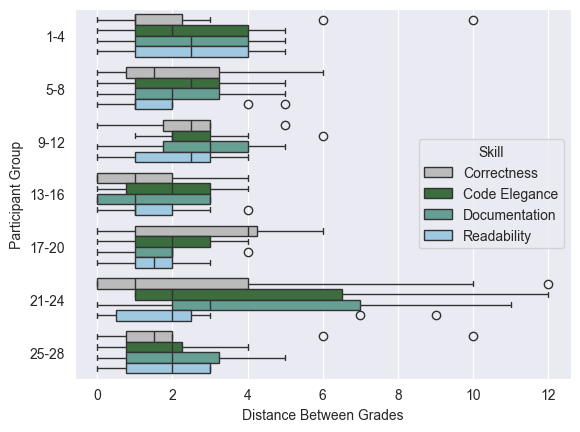

In [29]:
# TODO: Aggregate
fine_dist_df = get_distance_df(grade_df, 'grade').sort_values(by='group')
g = sns.boxplot(fine_dist_df, y='group', x='distance', hue='skill', palette=color_palette)
g.set(xlabel='Distance Between Grades', ylabel='Participant Group')
g.legend(title='Skill')
g.get_figure().savefig('plots/fine_grade_distance.pdf', bbox_inches='tight')

  0%|          | 0/7 [00:00<?, ?it/s]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_46935/3626878353.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_df = pd.concat([dist_df, generate_grade_pairs(df, grade_col, group, skill, n)])
 14%|█▍        | 1/7 [00:01<00:07,  1.25s/it]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_46935/195055873.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  grade_pairs_df = pd.concat([
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/

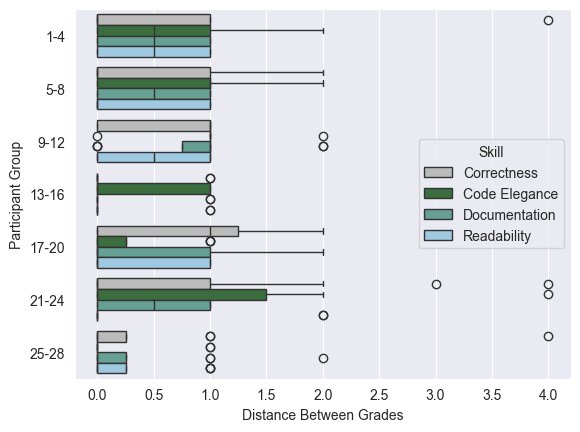

In [30]:
coarse_dist_df = get_distance_df(grade_df, 'primary_grade').sort_values(by='group')
g = sns.boxplot(coarse_dist_df, y='group', x='distance', hue='skill', palette=color_palette)
g.set(xlabel='Distance Between Grades', ylabel='Participant Group')
g.legend(title='Skill')
g.get_figure().savefig('plots/coarse_grade_distance.pdf', bbox_inches='tight')

#### Detailed heatmap

In [31]:
def generate_heatmap_data(skill, group):
    temp_df = dist_df[(dist_df['skill'] == skill) & (dist_df['group'] == group)].sort_values(['participant_id_1', 'participant_id_2'])

    temp_df = temp_df.pivot_table(index='participant_id_1', columns='participant_id_2', values='distance')
    return temp_df

In [32]:
skills = dist_df['skill'].unique()
groups = dist_df['group'].unique()
g = sns.FacetGrid(dist_df, row='group', col='skill',
                  col_order=skills, row_order=groups, sharey=False, sharex=False)
g.set_titles('{row_var} = {row_name} \n {col_var} = {col_name}')

for col_idx, group in enumerate(groups):
    for row_idx, skill in enumerate(skills):
        print(group, skill)
        a = sns.heatmap(ax=g.axes[col_idx, row_idx], data=generate_heatmap_data(skill=skill, group=group), square=True, cmap=sns.color_palette("mako", as_cmap=True), annot=True, vmin=dist_df['distance'].min(), vmax=dist_df['distance'].max())
        a.set(xlabel='', ylabel='')
        a.invert_yaxis()


g.savefig('plots/inter_rater_grade_dist.pdf', bbox_inches='tight')

NameError: name 'dist_df' is not defined

# Intra-Rater Relability

In [ ]:
DUPLICATE_MAP = {
    680: 144,
    681: 559,
    682: 97,
    683: 358,
    684: 389,
    685: 160,
    686: 176
}

In [ ]:
intra_rater_df = grade_df[grade_df['assignment_number'].isin(list(DUPLICATE_MAP.keys())+list(DUPLICATE_MAP.values()))][['assignment_number', 'skill', 'participant_id', 'batch', 'grade']]
intra_rater_df = intra_rater_df.sort_values('grade')
intra_rater_df

### Map replacement IDs to original IDs

In [ ]:
intra_rater_df['assignment_number'] = intra_rater_df['assignment_number'].apply(lambda x: x if x not in DUPLICATE_MAP.keys() else DUPLICATE_MAP[x])
intra_rater_df['grade_code'] = intra_rater_df['grade'].cat.codes
intra_rater_df

In [ ]:
pivot = intra_rater_df.pivot(index=['assignment_number', 'skill', 'participant_id'], columns='batch', values='grade').reset_index()
pivot.columns = ['assignment_number', 'skill', 'participant_id', 'grade_1', 'grade_2']
pivot

## Distance between grade notches

In [ ]:
pivot['grade_1_code'] = pivot['grade_1'].cat.codes
pivot['grade_2_code'] = pivot['grade_2'].cat.codes
pivot['distance'] = pivot['grade_1_code'] - pivot['grade_2_code']
pivot

In [ ]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Correctness'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Correctness'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)
    
dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Correctness', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/correctness_distance.pdf', bbox_inches='tight')

In [ ]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Code Elegance', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/code_elegance_distance.pdf', bbox_inches='tight')

In [ ]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Readability'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Readability'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Readability', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/readability_distance.pdf', bbox_inches='tight')

In [ ]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Documentation'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Documentation'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Documentation', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/documentation_distance.pdf', bbox_inches='tight')

# Summary of Grades per skill

In [ ]:
grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})
grade_count_df

In [ ]:
grade_plt = sns.barplot(x='grade', y='count', data=grade_count_df, hue='skill')

hatches = ['//', 'x', '\\', 'o']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, grade_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

grade_plt.set(xlabel='Grade', ylabel='Count')
handles = grade_plt.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')


grade_plt.legend(title='Same Grade')
grade_plt.get_figure().savefig('plots/grade_count.pdf', bbox_inches='tight')

In [ ]:
lower_b = grade_count_df[~grade_count_df['grade'].isin(['A++', 'A+', 'A', 'A-', 'B+', 'B', 'B-'])]['count'].sum()

(lower_b / grade_count_df['count'].sum()) * 100